<a href="https://colab.research.google.com/github/hengjunzhang/513-final/blob/main/Copy_of_513_image_enhancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow tensorflow-datasets matplotlib


In [ ]:
!pip install tensorflow-datasets


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Dowanload DIV2K
div2k, div2k_info = tfds.load('div2k/bicubic_x4', split='train', with_info=True)

print(div2k_info)



EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteZWDMAA/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteZWDMAA/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='div2k',
    full_name='div2k/bicubic_x4/2.0.0',
    description="""
    DIV2K dataset: DIVerse 2K resolution high quality images as used for the
    challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)
    """,
    config_description="""
    Uses bicubic_x4 data.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    data_dir=PosixGPath('/tmp/tmpvpwri3f1tfds'),
    file_format=tfrecord,
    download_size=3.97 GiB,
    dataset_size=3.97 GiB,
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=uint8),
        'lr': Image(shape=(None, None, 3), dtype=uint8),
    }),
    supervised_keys=('lr', 'hr'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=800, num_shards=32>,
        'validation': <SplitInfo num_examples=100, num_shards=4>,
    },


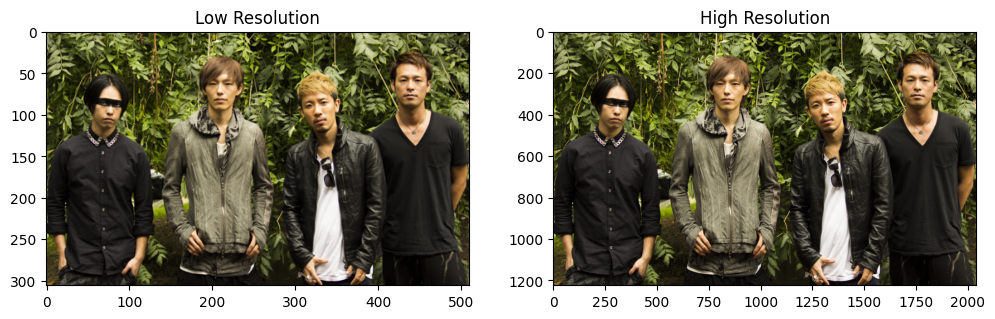

In [ ]:
# Load Dataset
div2k_train = tfds.load('div2k/bicubic_x4', split='train', as_supervised=False)

# To demonstrate, we will take a sample from the dataset
for example in div2k_train.take(1):  # Iterate only once
    lr_image = example['lr']  # Low resolution images
    hr_image = example['hr']  # High resolution images

    # Use matplotlib to show these two images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Low Resolution')
    plt.imshow(lr_image.numpy())

    plt.subplot(1, 2, 2)
    plt.title('High Resolution')
    plt.imshow(hr_image.numpy())
    plt.show()


In [ ]:
# Load training and validation sets
div2k_train = tfds.load('div2k/bicubic_x4', split='train', as_supervised=False)
div2k_valid = tfds.load('div2k/bicubic_x4', split='validation', as_supervised=False)

# Defining preprocessor functions
def preprocess(features):
    hr_image = features['hr']
    lr_image = features['lr']

    # Setting the target image size
    target_height, target_width = 256, 256

    # Adjusting the image size
    hr_image = tf.image.resize(hr_image, [target_height, target_width])
    lr_image = tf.image.resize(lr_image, [target_height // 4, target_width // 4])

    # Normalized to [0, 1]
    hr_image = tf.cast(hr_image, tf.float32) / 255.0
    lr_image = tf.cast(lr_image, tf.float32) / 255.0

    return lr_image, hr_image

# Application preprocessing and batch processing
train_dataset = div2k_train.map(preprocess).batch(16)
valid_dataset = div2k_valid.map(preprocess).batch(16)



In [ ]:
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D
from tensorflow.keras.models import Model

def build_sr_model(input_shape=(64, 64, 3)):
    inputs = Input(shape=input_shape)
    # Enlargement of image size using an upsampling layer
    x = UpSampling2D(size=(4, 4))(inputs)  # Zoom in 4x
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2D(3, (3, 3), activation='linear', padding='same')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_sr_model()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 256, 256, 3)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       1731      
                                                                 
Total params: 40451 (158.01 KB)
Trainable params: 40451 (158.01 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)


Epoch 1/10
50/50 [==============================] - 598s 12s/step - loss: 0.0287 - val_loss: 0.0142
Epoch 2/10
50/50 [==============================] - 599s 12s/step - loss: 0.0134 - val_loss: 0.0136
Epoch 3/10
50/50 [==============================] - 587s 11s/step - loss: 0.0129 - val_loss: 0.0132
Epoch 4/10
50/50 [==============================] - 578s 11s/step - loss: 0.0126 - val_loss: 0.0131
Epoch 5/10
50/50 [==============================] - 576s 11s/step - loss: 0.0125 - val_loss: 0.0130
Epoch 6/10
50/50 [==============================] - 613s 12s/step - loss: 0.0125 - val_loss: 0.0130
Epoch 7/10
50/50 [==============================] - 584s 11s/step - loss: 0.0125 - val_loss: 0.0130
Epoch 8/10
50/50 [==============================] - 576s 11s/step - loss: 0.0125 - val_loss: 0.0130
Epoch 9/10
50/50 [==============================] - 577s 11s/step - loss: 0.0125 - val_loss: 0.0130
Epoch 10/10
50/50 [==============================] - 581s 11s/step - loss: 0.0125 - val_loss: 0.0129

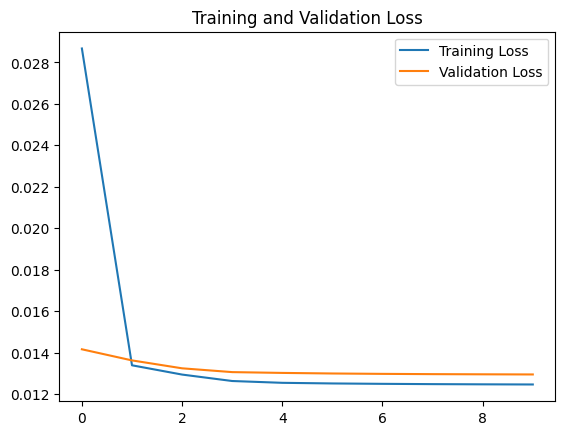

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

# upload
image_path = list(uploaded.keys())[0]


Saving blurry.jpg to blurry.jpg


1/1 [==============================] - 1s 551ms/step


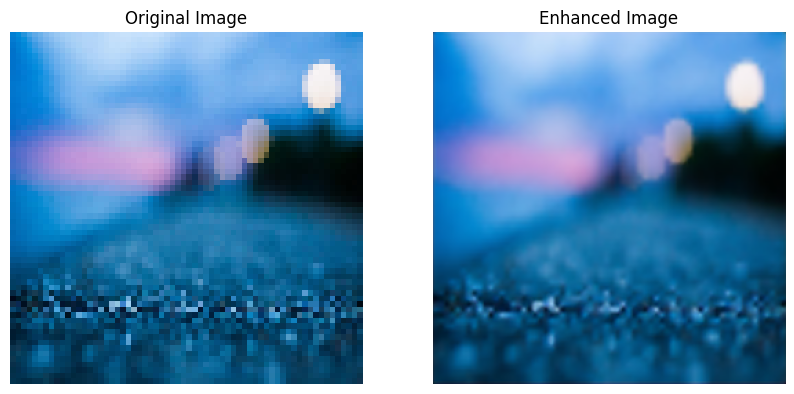

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Reload and preprocess images
img = load_img('blurry.jpg')  # Load Image
img = img_to_array(img)  # Converting images to arrays
img = np.expand_dims(img, axis=0)  # Add a batch dimension
img = tf.image.resize(img, [64, 64])  # Resize image to match model input
img = img / 255.0  # Normalized to [0, 1]
# Prediction using models
sr_img = model.predict(img)

# Preparing to show images
sr_img = np.clip(sr_img, 0, 1)
sr_img = sr_img[0] * 255.0  # Remove batch dimension and convert back to [0, 255]
sr_img = sr_img.astype('uint8')  # convert to an integer (math.)

# Show original and enhanced images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(tf.cast(tf.image.resize(load_img('blurry.jpg'), [64, 64]), tf.uint8))  # Original image after resizing
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(sr_img)
plt.axis('off')

plt.show()
